[download the dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/download?datasetVersionNumber=1)

In [1]:
# Import necessary libraries
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Data split and preprocessing

In [ ]:
# Load data and preprocess it
def load_data():
    df = pd.read_csv('healthcare-dataset-stroke-data.csv')

    # id column has no relationship with stroke, drop it.
    # only one no-stroke data point with gender 'Other', drop it for the convenience of One-hot encoding
    df = df.drop('id', axis=1)
    df = df[df.gender != 'Other']

    # classify the features
    categorical_features = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'gender']
    numerical_features = ['avg_glucose_level', 'bmi', 'age']

    # split label and features
    y = df['stroke']
    X = df.drop('stroke', axis=1)

    return X, y, categorical_features, numerical_features

X, y, categorical_features, numerical_features = load_data()

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a column transformer for preprocessing numerical and categorical features separately
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical features preprocessing
        ('num', Pipeline([
            # Median imputation for missing values
            ('imputer', SimpleImputer(strategy='median')),
            # feature scaling
            ('scaler', StandardScaler())
        ]), numerical_features),

        # Categorical features preprocessing
        ('cat', Pipeline([
            # One-hot encoding
            ('onehot', OneHotEncoder())
        ]), categorical_features)
    ])

# Cross validation and model selection

In [ ]:
# calculate the max k for KNN
def get_the_max_k():
  # calculate the number of positive and negative train set points
  pos_num = sum(y_train==1)
  neg_num = sum(y_train==0)
  # calculate number of total train set points after SMOTE over-sampling
  # SMOTE over-sampling makes minority classes the same amount as the majority classes
  total_num = max(pos_num,neg_num)*2
  # calculate the max k with Rule of thumb
  max_k = round(np.sqrt(total_num))
  return max_k
max_k = get_the_max_k()

# Create classifier models
def get_models():
    # create empty model dict
    models = {}

    # KNN with different K values using manhattan_distance
    for i in range(3, max_k, 6):
        model_name = 'knn_manhattan_' + str(i)
        model = KNeighborsClassifier(n_neighbors=i,metric='minkowski',p=1)
        models[model_name] = model

    # KNN with different K values using euclidean_distance
    for i in range(3, max_k, 6):
        model_name = 'knn_euclidean_' + str(i)
        model = KNeighborsClassifier(n_neighbors=i,metric='minkowski',p=2)
        models[model_name] = model

    # Logistic Regression with L1 penalty
    model_name = 'LR_with_l1'
    model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
    models[model_name] = model

    return models

# Create models and evaluate them
models = get_models()
evaluation_score = pd.DataFrame()

# Iterate through models
for model_name, model in models.items():
    # Get model type and K value
    model_type = 'knn_manhattan' if 'manhattan' in model_name else 'knn_euclidean' if 'euclidean' in model_name else 'LR_with_l1'
    k_value = int(model_name.split('_')[-1]) if 'knn' in model_name else np.nan

    # Create a pipeline that includes data preprocessing, SMOTE over-sampling, and model training
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('over', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Perform StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_validate(model_pipeline, X_train, y_train, scoring=['roc_auc', 'f1', 'f1_macro', 'f1_weighted', 'recall', 'precision'], cv=cv)
    scores_mean = {metric_name: np.mean(metric) for metric_name, metric in scores.items()}

    # Create a new row for evaluation scores
    new_row = pd.Series({'Model_type': model_type, 'K': k_value, **scores_mean})
    evaluation_score = pd.concat([evaluation_score, new_row.to_frame().T])

# Rename columns and calculate total time
evaluation_score.rename(columns=lambda x: x.replace('test', 'evaluation'), inplace=True)
evaluation_score['total_time'] = evaluation_score.fit_time + evaluation_score.score_time

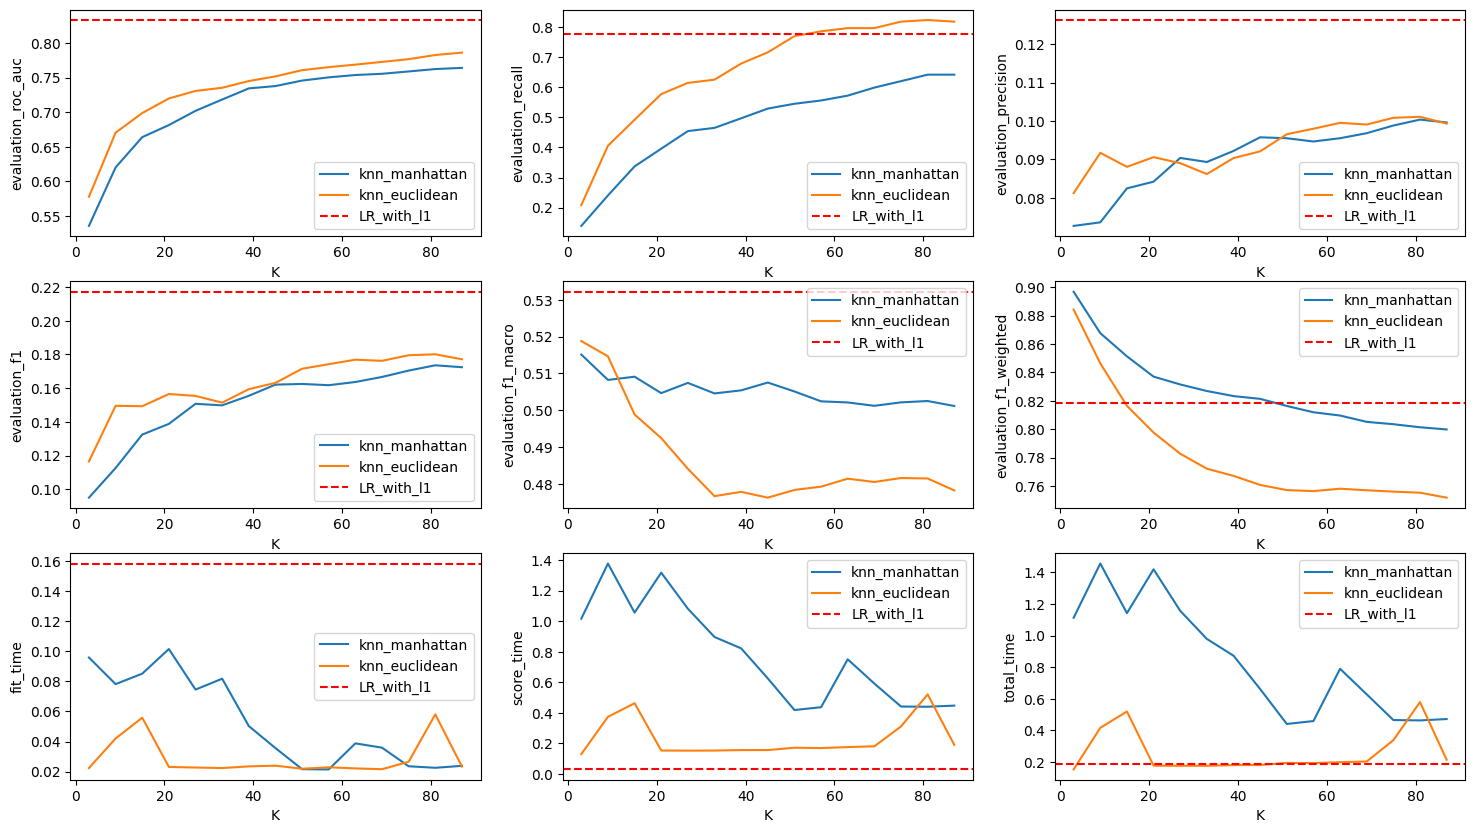

In [ ]:
# Filter evaluation scores for KNN models (excluding LR_with_l1)
evaluation_knn = evaluation_score[evaluation_score['Model_type'] != 'LR_with_l1']

# Create a figure for the chart
plt.figure(figsize=(18, 10))

# Define the list of metrics to plot
metrics_to_plot = ['evaluation_roc_auc', 'evaluation_recall', 'evaluation_precision',
                   'evaluation_f1', 'evaluation_f1_macro', 'evaluation_f1_weighted',
                   'fit_time', 'score_time', 'total_time']

# Iterate through the metrics and create subplots
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(3, 3, i + 1)

    # Plot lines for KNN models with different values of K and different distance type
    sns.lineplot(data=evaluation_knn, x='K', y=metric, hue='Model_type')

    # Add a horizontal line for LR_with_l1 values
    plt.axhline(y=evaluation_score[evaluation_score['Model_type'] == 'LR_with_l1'][metric].iloc[0], color='red', linestyle='--', label='LR_with_l1')

    # Add a legend to the subplot
    plt.legend()

# Show the chart
plt.show()


# Selected models' performance on testing data sets


According to the K fold cross_validate results on training Set, we choose logistic regression with L1 penalty and knn_euclidean_19 as our selected models.

## Logistic Regression model with L1 penalty

In [ ]:
# Create a Logistic Regression model with L1 penalty
selected_model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')

# Create a pipeline that includes data preprocessing, SMOTE over-sampling, and model training
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('over', SMOTE(random_state=42)),
    ('classifier', selected_model)
])

# Fit the training set
model_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Print classification report
print('classification report for training set:')
print(classification_report(y_train, y_train_pred))
print('classification report for testing set:')
print(classification_report(y_test, y_test_pred))

# Print AUC score
print('AUC score for training set is:', round(roc_auc_score(y_train, model_pipeline.predict_proba(X_train)[:, 1]),4))
print('AUC score for testing set is:', round(roc_auc_score(y_test, model_pipeline.predict_proba(X_test)[:, 1]),4))

classification report for training set:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3900
           1       0.13      0.80      0.22       187

    accuracy                           0.74      4087
   macro avg       0.56      0.77      0.53      4087
weighted avg       0.95      0.74      0.82      4087

classification report for testing set:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       960
           1       0.16      0.81      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.77      0.56      1022
weighted avg       0.93      0.74      0.80      1022

AUC score for training set is: 0.8451
AUC score for testing set is: 0.8423


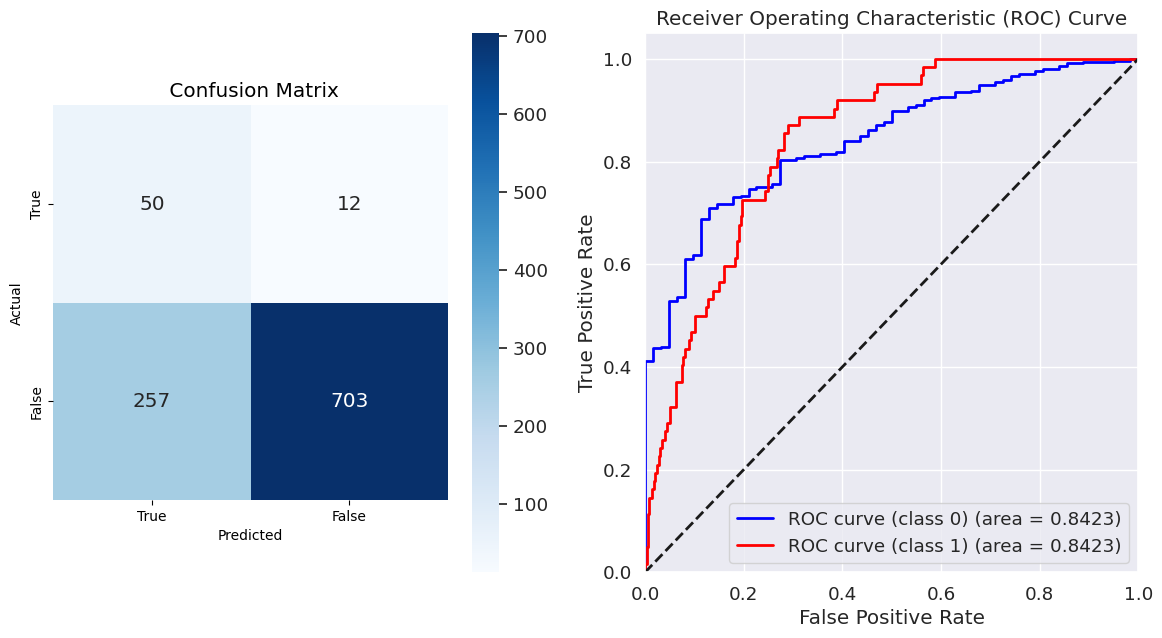

In [ ]:
# Create a figure with two subplots
plt.figure(figsize=(14, 7))

# Subplot 1: Confusion Matrix
plt.subplot(1, 2, 1)

def plot_confusion_matrix(true_labels, predictions, title=""):
    # Create a confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    # Swap positions of true negatives and true positives
    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]
    cm[0, 1], cm[1, 0] = cm[1, 0], cm[0, 1]

    # Plot the confusion matrix using seaborn and matplotlib
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True,
                xticklabels=['True', 'False'],
                yticklabels=['True', 'False'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title + ' Confusion Matrix')

plot_confusion_matrix(y_test, y_test_pred, title="")

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), model_pipeline.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['blue', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the figure with both subplots
plt.show()

## KNN using euclidean distance with K=19

In [ ]:
# Create a KNN model with using euclidean distance with K=19
selected_model = KNeighborsClassifier(n_neighbors=19,metric='minkowski',p=2)

# Create a pipeline that includes data preprocessing, SMOTE over-sampling, and model training
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('over', SMOTE(random_state=42)),
    ('classifier', selected_model)
])

# Fit the training set
model_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Print classification report
print('classification report for training set:')
print(classification_report(y_train, y_train_pred))
print('classification report for testing set:')
print(classification_report(y_test, y_test_pred))

# Print AUC score
print('AUC score for training set is:', round(roc_auc_score(y_train, model_pipeline.predict_proba(X_train)[:, 1]),4))
print('AUC score for testing set is:', round(roc_auc_score(y_test, model_pipeline.predict_proba(X_test)[:, 1]),4))

classification report for training set:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      3900
           1       0.16      0.99      0.28       187

    accuracy                           0.76      4087
   macro avg       0.58      0.87      0.57      4087
weighted avg       0.96      0.76      0.83      4087

classification report for testing set:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       960
           1       0.13      0.63      0.22        62

    accuracy                           0.72      1022
   macro avg       0.55      0.68      0.52      1022
weighted avg       0.92      0.72      0.79      1022

AUC score for training set is: 0.9712
AUC score for testing set is: 0.7609


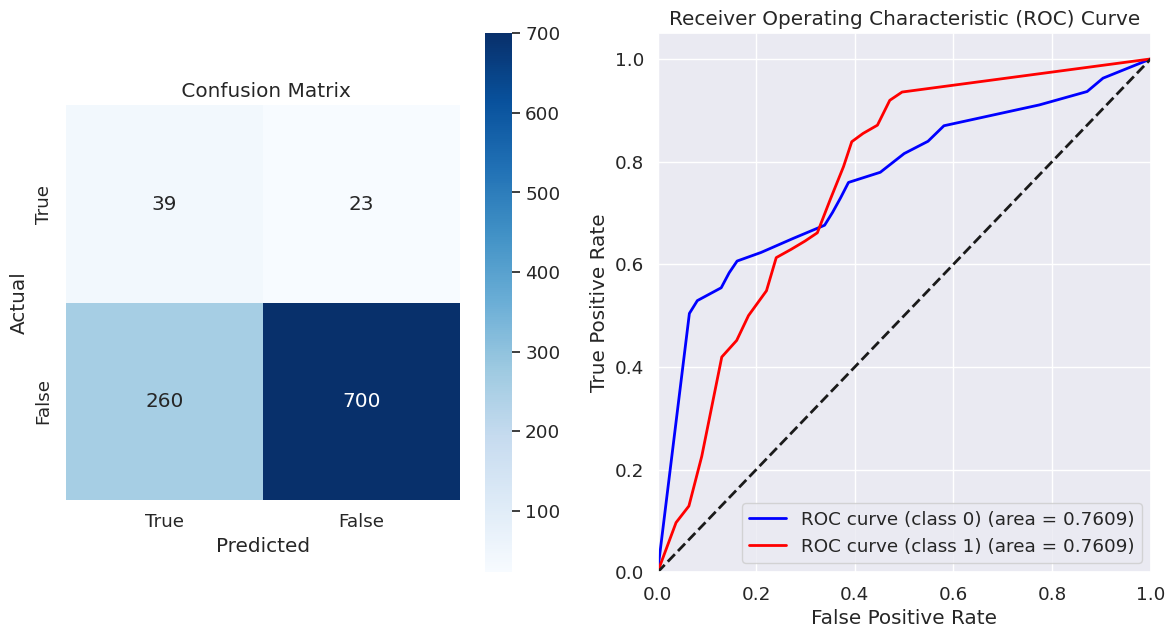

In [ ]:
# Create a figure with two subplots
plt.figure(figsize=(14, 7))

# Subplot 1: Confusion Matrix
plt.subplot(1, 2, 1)

def plot_confusion_matrix(true_labels, predictions, title=""):
    # Create a confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    # Swap positions of true negatives and true positives
    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]
    cm[0, 1], cm[1, 0] = cm[1, 0], cm[0, 1]

    # Plot the confusion matrix using seaborn and matplotlib
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True,
                xticklabels=['True', 'False'],
                yticklabels=['True', 'False'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title + ' Confusion Matrix')

plot_confusion_matrix(y_test, y_test_pred, title="")

# Subplot 2: ROC Curve
plt.subplot(1, 2, 2)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), model_pipeline.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = ['blue', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the figure with both subplots
plt.show()